<a href="https://colab.research.google.com/github/Nourbh17/Food-Recognition-and-calories-Estimation-ComputerVision/blob/main/Calories_Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

### In this part Im going to work on :

*   segementation
*   measure the dish of the meal so i could find the mass and the total calories of that meal : using the volume, mass and calories per 100grm





# Segmentation


*   Convert to Grayscale and Apply Median Blur
*   Find the Largest Contour


*   Remove the Plate
*   Remove the Skin


*   Process the Food (the fruit in this case)
*   Calculate the Fruit Area


*   Calculate the Skin Area













In [ ]:
from google.colab.patches import cv2_imshow
import cv2

def Segmentation(img1):
    img = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img_filt = cv2.medianBlur(img, 5)    #Apply a median blur to reduce noise
    #Adaptive thresholding is a technique where the threshold value is determined for smaller regions of the image, which allows for
    #different lighting conditions in different areas of the image. This is particularly useful for images with varying illumination.
    #cv2.THRESH_BINARY: Pixels are set to the maxValue if the value is greater than the threshold value, otherwise set to 0.
    #cv2.ADAPTIVE_THRESH_GAUSSIAN_C: The threshold value is a weighted sum (Gaussian window) of the neighborhood values.
    img_th = cv2.adaptiveThreshold(img_filt, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE) #Detect contours in a binary image  #cv2.RETR_LIST: Retrieves all contours without establishing any hierarchical relationships.

    # find contours. sort. and find the biggest contour. the biggest contour corresponds to the plate and food.
    mask = np.zeros(img.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask, [largest_areas[-1]], 0, (255,255,255,255), -1)
    img_bigcontour = cv2.bitwise_and(img1,img1,mask = mask)

    # convert to hsv.
    # remove plate
    # detect food skin
    hsv_img = cv2.cvtColor(img_bigcontour, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv_img)
    mask_plate = cv2.inRange(hsv_img, np.array([0,0,100]), np.array([255,90,255]))
    mask_not_plate = cv2.bitwise_not(mask_plate)
    food_skin = cv2.bitwise_and(img_bigcontour,img_bigcontour,mask = mask_not_plate)

    #convert to hsv to detect and remove skin pixels
    hsv_img = cv2.cvtColor(food_skin, cv2.COLOR_BGR2HSV)
    skin = cv2.inRange(hsv_img, np.array([0,10,60]), np.array([10,160,255])) #Scalar(0, 10, 60), Scalar(20, 150, 255)
    not_skin = cv2.bitwise_not(skin); #invert skin and black
    food = cv2.bitwise_and(food_skin,food_skin,mask = not_skin) #get only food pixels

    food_bw = cv2.cvtColor(food, cv2.COLOR_BGR2GRAY)
    food_bin = cv2.inRange(food_bw, 10, 255) #binary of food

    #erode before finding contours
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    erode_food = cv2.erode(food_bin,kernel,iterations = 1)

    #find largest contour since that will be the food
    img_th = cv2.adaptiveThreshold(erode_food,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_food = np.zeros(food_bin.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask_food, [largest_areas[-2]], 0, (255,255,255), -1)

    #dilate now
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
    mask_food2 = cv2.dilate(mask_food,kernel2,iterations = 1)
    res = cv2.bitwise_and(food_bin,food_bin,mask = mask_food2)
    food_final = cv2.bitwise_and(img1,img1,mask = mask_food2)


    #find area of food
    img_th = cv2.adaptiveThreshold(mask_food2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    largest_areas = sorted(contours, key=cv2.contourArea)
    food_contour = largest_areas[-2]
    food_area = cv2.contourArea(food_contour)

    #finding the area of skin. find area of biggest contour
    skin2 = skin - mask_food2
    #erode before finding contours
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    skin_e = cv2.erode(skin2,kernel,iterations = 1)
    img_th = cv2.adaptiveThreshold(skin_e,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    contours, hierarchy = cv2.findContours(img_th, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask_skin = np.zeros(skin.shape, np.uint8)
    largest_areas = sorted(contours, key=cv2.contourArea)
    cv2.drawContours(mask_skin, [largest_areas[-2]], 0, (255,255,255), -1)

    skin_rect = cv2.minAreaRect(largest_areas[-2])
    box = cv2.boxPoints(skin_rect)
    box = np.int0(box)
    mask_skin2 = np.zeros(skin.shape, np.uint8)
    cv2.drawContours(mask_skin2,[box],0,(255,255,255), -1)

    pix_height = max(skin_rect[1])
    pix_to_cm_multiplier = 5.0/pix_height
    skin_area = cv2.contourArea(box)


    return food_area, mask_food2, food_final, skin_area, food_contour, pix_to_cm_multiplier

<ipython-input-38-317fe030d7a6>:76: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


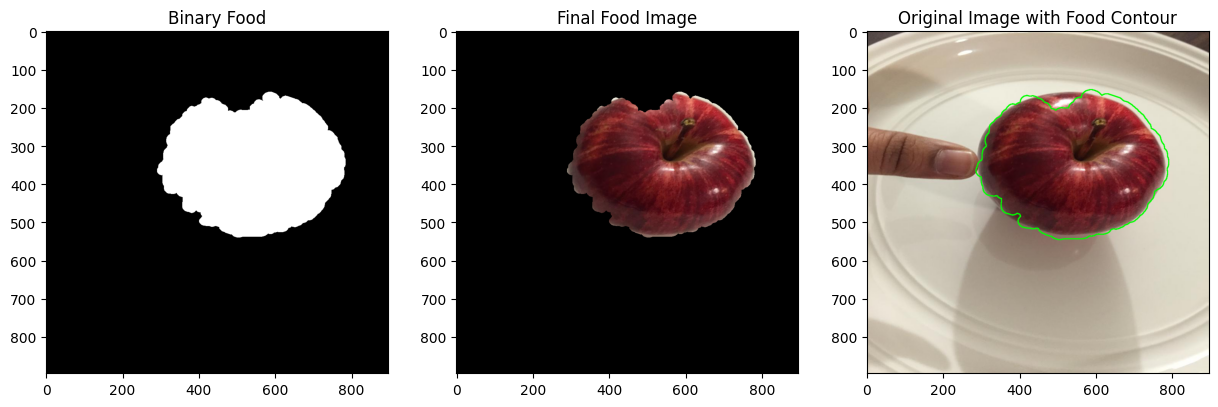

Food Area: 145307.5
Skin Area: 32379.5
Pixel to CM Multiplier: 0.01707044172372703


In [ ]:
#Example


img1_path = '/content/drive/MyDrive/ProjectInternship/dataset_fruits.yolov8/test/images/Apple_58_jpg.rf.8dad125130c22b1957be79b7ecc2e55c.jpg'
img1= cv2.imread(img1_path)
area, bin_food, img_food, skin_area, food_contour, pix_to_cm_multiplier = Segmentation(img1)

plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.title('Binary Food')
plt.imshow(bin_food, cmap='gray')

plt.subplot(1, 3, 2)
plt.title('Final Food Image')
plt.imshow(cv2.cvtColor(img_food, cv2.COLOR_BGR2RGB))

plt.subplot(1, 3, 3)
plt.title('Original Image with Food Contour')
cv2.drawContours(img1, [food_contour], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

plt.show()

print(f"Food Area: {area}")
print(f"Skin Area: {skin_area}")
print(f"Pixel to CM Multiplier: {pix_to_cm_multiplier}")

In [ ]:
density_dict = { "Apple":0.96, "Banana":0.94,  "Carrot":0.641,"Onion":0.513, "Orange":0.482,"Tomato":0.481 , "Qiwi" :0.575 }
#kcal
calorie_dict = { "Apple":52, "Banana":89,  "Carrot":41 , "Onion":40 , "Orange":47 , "Tomato":18 , "Qiwi":44 }

#skin of photo to real multiplier
skin_multiplier = 5*2.3

#                0        1        2          3        4        5         6         7
label_list = ["thumb" , "Apple", "Banana", "Orange", "Qiwi", "Tomato", "Carrot", "Onion" ]

In [ ]:
def getVolume(label, area, skin_area, pix_to_cm_multiplier, fruit_contour):
    area_fruit = (area/skin_area)*skin_multiplier #area in cm^2
    volume = 100

    if label == label_list[1] or label == label_list[3] or label == label_list[4] or label == label_list[5] or label == label_list[7] : #sphere-apple,orange,kiwi,tomato,onion
        radius = np.sqrt(area_fruit/np.pi)
        volume = (4/3)*np.pi*radius*radius*radius
        #print (area_fruit, radius, volume, skin_area)

    if label == label_list[2] or label == label_list[6] and area_fruit > 30 : #cylinder like banana, cucumber, carrot
        fruit_rect = cv2.minAreaRect(fruit_contour)
        height = max(fruit_rect[1])*pix_to_cm_multiplier
        radius = area_fruit/(2.0*height)
        volume = np.pi*radius*radius*height

    if (label==label_list[6] and area_fruit < 30) : # carrot
        volume = area_fruit*0.5 #assuming width = 0.5 cm

    return volume


In [ ]:
#Inputs are the volume of the food item and the label of the food item
#so that the food item can be identified uniquely.
#The calorie content in the given volume of the food item is calculated
def getCalorie(label, volume): #volume in cm^3
    calorie = calorie_dict[label]
    density = density_dict[label]
    if (volume == None):
      return None, None, calorie
    mass = volume*density*1.0
    calorie_tot = (calorie/100.0)*mass
    return mass, calorie_tot, calorie #calorie per 100 grams


In [ ]:
V = getVolume("Apple", area, skin_area, pix_to_cm_multiplier, food_contour)
mass, calorie_tot, calorie= getCalorie("Apple", V)
print(mass,calorie_tot, calorie )

267.73714800446305 139.22331696232078 52


# Test the model :


In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()
# !yolo mode=checks

In [ ]:
img1_path = '/content/drive/MyDrive/ProjectInternship/dataset_fruits.yolov8/test/images/Apple_58_jpg.rf.8dad125130c22b1957be79b7ecc2e55c.jpg'

!yolo task=detect mode=predict model='/content/drive/MyDrive/ProjectInternship/train/weights/best.pt' conf=0.25 source='/content/drive/MyDrive/ProjectInternship/dataset_fruits.yolov8/test/images/Apple_58_jpg.rf.8dad125130c22b1957be79b7ecc2e55c.jpg' project='/content/drive/MyDrive/ProjectInternship'


Ultralytics YOLOv8.2.50 🚀 Python-3.10.12 torch-2.3.0+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11128680 parameters, 0 gradients, 28.5 GFLOPs

image 1/1 /content/drive/MyDrive/ProjectInternship/dataset_fruits.yolov8/test/images/Apple_58_jpg.rf.8dad125130c22b1957be79b7ecc2e55c.jpg: 800x800 1 Apple, 1 thumb, 1000.8ms
Speed: 22.1ms preprocess, 1000.8ms inference, 31.9ms postprocess per image at shape (1, 3, 800, 800)
Results saved to /content/drive/MyDrive/ProjectInternship/predict3
💡 Learn more at https://docs.ultralytics.com/modes/predict


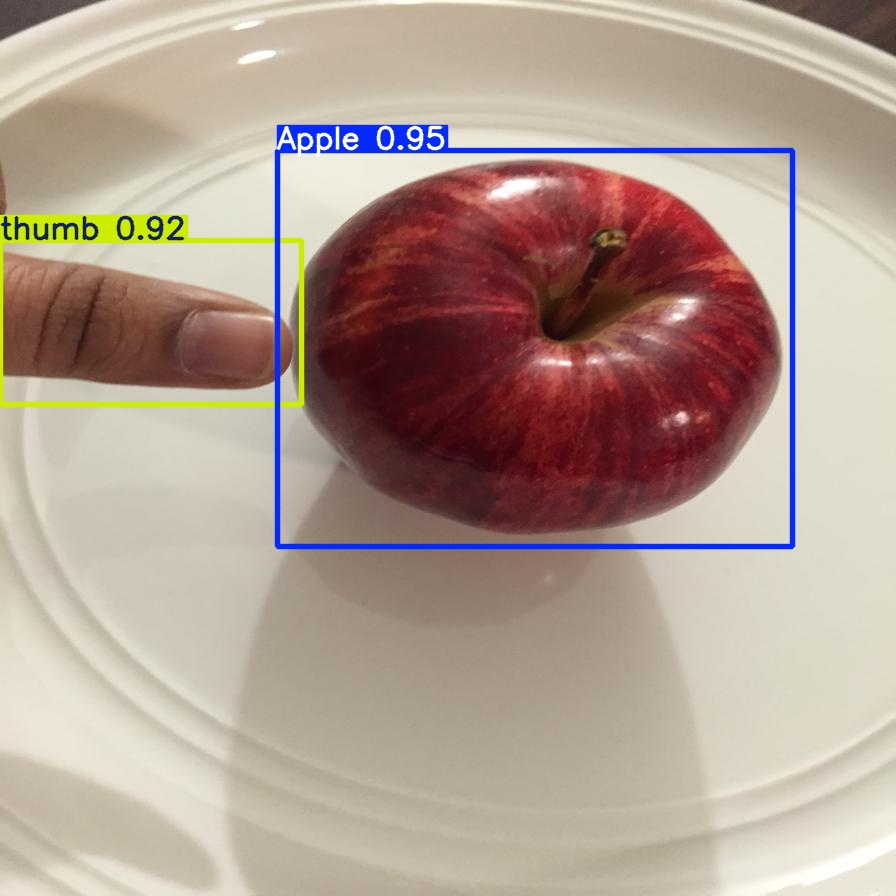

In [ ]:
import glob
from IPython.display import Image, display

for img_path in glob.glob(f'/content/drive/MyDrive/ProjectInternship/predict3/*.jpg')[:]:
  display(Image(filename=img_path, width=600))
  print("\n")